# Qubit characterization

In this lab, we perform the first steps that are required for operating a superconducting quantum processor. 

### 0. Getting Started

First, we need to import the Qiskit Pulse packages we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib

from scipy.signal import savgol_filter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Here we define helper functions that we will use throughout this notebook

In [44]:
from scipy.optimize import curve_fit

def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def process_reflective_measurement(freqs,values):
    #phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),5,3),freqs)
    phase_grad = np.gradient(np.unwrap(np.angle(values)),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

def f_sine(t, fs, a, offs, ph):
    return a*np.sin(2*np.pi*fs*t+ph)+offs

def fit_rabi(x, y):
    p0=[1/np.median(x)/2 , np.max(y), np.min(y), np.pi/2]
    return curve_fit(f_sine, x, y, p0=p0)

For this lab we will use the ***ibmq_armonk*** backend, which is capable of pulse-level control. The time unit of our pulse control is set by the resolution of analog waveform generators that are used to operator the backend.

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
#backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []

inst_sched_map = backend.defaults().instruction_schedule_map

dt=backend_config.dt   # hardware resolution

In our processors each qubit has three relevent channels:
1. The ***drive channel** is use used for performing qubit gates
2. The **measurement channel*** is used for probing the resonator coupled to the qubit, which is used for qubit readout
3. The **acquire channel*** is used for aquiring the signal during the resonator measurement pulse

In [4]:
qubit=0   # qubit used in our experiment

drive_chan = pulse.DriveChannel(qubit)  # microwave drive channel
meas_chan = pulse.MeasureChannel(qubit) # resonator channel
acq_chan = pulse.AcquireChannel(qubit)  # readout signal acquisition channel

### Resonator spectroscopy

The first step in characterizing a qubit it finding the resonance frequency of the resonator coupled to the qubit. The resonator frequency can be used for probing the state of the qubit; In the dispersive regime, the resonator frequency changes depending on the state of the qubit.

First, we set the duration and the amplitude of the readout pulse.

In [5]:
readout_duration=5e-6
readout_amp=0.1 # try lower power

The readout sequence consists of a readout pulse through the the measurement channel, while simultaneously acquiring the signal from the resonator. Here, we use a [GaussianSquare](https://qiskit.org/documentation/stubs/qiskit.pulse.GaussianSquare.html#qiskit.pulse.GaussianSquare) pulse with a Gaussian rise/fall and a constant plateau.

In [6]:
with pulse.build(name='readout',backend=backend) as readout:
    with pulse.align_left():
        pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(readout_duration//dt), readout_amp, get_closest_multiple_of_16(20e-9//dt), risefall_sigma_ratio=1), meas_chan)
        pulse.acquire(get_closest_multiple_of_16(readout_duration//dt), acq_chan, pulse.MemorySlot(0))

In [28]:

frequency_sweep_detunings=np.linspace(-6e6,6e6,31)
readout_pulses=[]
for detuning in frequency_sweep_detunings:
    with pulse.build(name='readout',backend=backend) as readout_pulse:
        with pulse.align_left():
            pulse.shift_frequency(detuning, meas_chan)
            pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(readout_duration//dt), readout_amp, get_closest_multiple_of_16(20e-9//dt), risefall_sigma_ratio=1), meas_chan)
            pulse.acquire(get_closest_multiple_of_16(readout_duration//dt), acq_chan, pulse.MemorySlot(0))
            
    readout_pulses.append(readout_pulse)

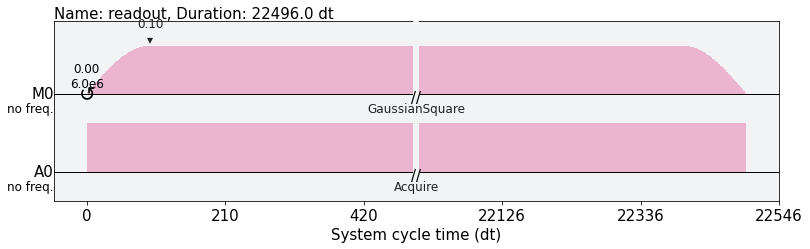

In [29]:
readout_pulses[30].draw(style=IQXDebugging())

We sweep the frequency of the readout probe, to find the resonance frequency of the resonator.

In [25]:
resonator_freq_guess = backend.defaults().meas_freq_est[qubit]  # an estimate for the resonator frequency
freq_span = 6e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = resonator_freq_guess+ np.linspace(-freq_span/2,freq_span/2,31)

readout_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [26]:
num_shots = 4*1024 
resonator_sweep = assemble(readout,
                           backend=backend, 
                           meas_level=1,
                           meas_return='avg',
                           shots=num_shots,
                           schedule_los=readout_frequencies)

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:447: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [30]:
num_shots = 2*1024 
resonator_sweep = assemble(readout_pulses,
                           backend=backend, 
                           meas_level=1,
                           meas_return='avg',
                           shots=num_shots)

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:447: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [32]:
job_resonator_sweep = backend.run(resonator_sweep)
job_monitor(job_resonator_sweep)

Job Status: job has successfully run


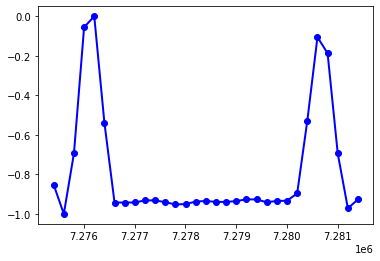

In [28]:
import matplotlib.pyplot as plt

resonator_sweep_results = job_resonator_sweep.result(timeout=120)

resonator_sweep_values = []
for i in range(len(resonator_sweep_results.results)):
    resonator_sweep_values.append(resonator_sweep_results.get_memory(i)[qubit])

resonator_sweep_values = process_reflective_measurement(frequencies_range, resonator_sweep_values)

plt.plot(frequencies_range/1e3, resonator_sweep_values,'-o', color='blue', lw=2)

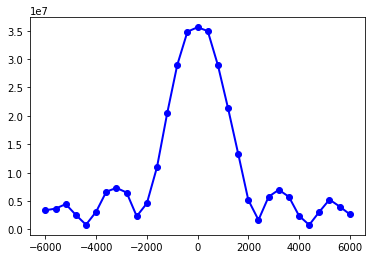

In [38]:
import matplotlib.pyplot as plt

resonator_sweep_results = job_resonator_sweep.result(timeout=120)

resonator_sweep_values = []
for i in range(len(resonator_sweep_results.results)):
    resonator_sweep_values.append(resonator_sweep_results.get_memory(i)[qubit])

#resonator_sweep_values = process_reflective_measurement(frequency_sweep_detunings, resonator_sweep_values)
resonator_sweep_values=np.abs(resonator_sweep_values)

plt.plot(frequency_sweep_detunings/1e3, resonator_sweep_values,'-o', color='blue', lw=2)

### Qubit spectroscopy

After finding the resonator frequency, we perform qubit spectroscopy to find the transition frequency between the $|0\rangle$ and the $|1\rangle$ states of the qubit. This frequency $f$ corresponds to the transition energy $E=h.f$, where $h$ is Planck's constant. In experiment, we find this transition frequency by sweeping the drive frequency of the qubit to find the frequency that causes a transition between the $|0\rangle$ and the $|1\rangle$ states.

For qubit spectroscopy we use a pulse with a long duration, and low amplitude.

In [31]:
spectroscopy_duration=.25e-6
spectroscopy_amp=.1

We use a GuassianSquare pulse for qubit spectroscopy, followed by the readout sequence.

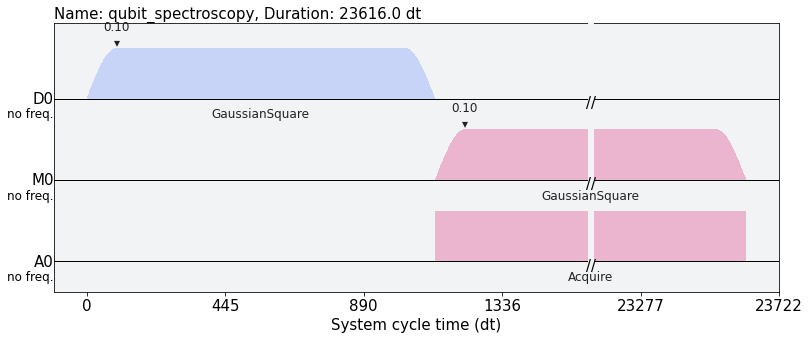

In [32]:
with pulse.build(name='qubit_spectroscopy',backend=backend) as qubit_spectroscopy:
    with pulse.align_sequential():
        pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(spectroscopy_duration//dt), spectroscopy_amp, get_closest_multiple_of_16(20e-9//dt), risefall_sigma_ratio=1), drive_chan)
        pulse.call(readout)
    
qubit_spectroscopy.draw(style=IQXDebugging())

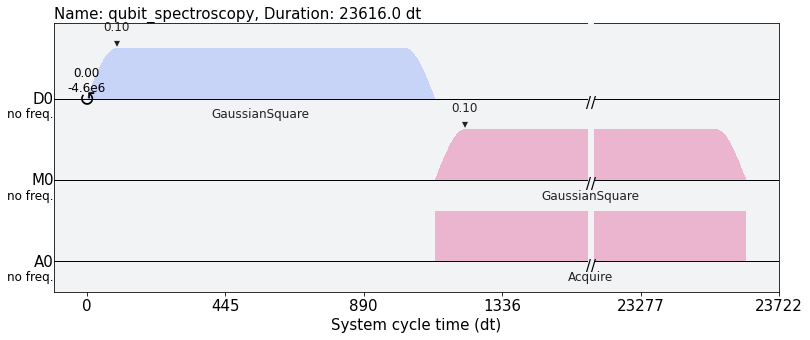

In [33]:
freq_detunings=np.linspace(-5e6, 5e6, 51)
qubit_spectroscopy_pulses=[]
for detuning in freq_detunings:
    with pulse.build(name='qubit_spectroscopy',backend=backend) as qubit_spectroscopy_pulse:
        with pulse.align_sequential():
            pulse.shift_frequency(detuning, drive_chan)
            pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(spectroscopy_duration//dt), spectroscopy_amp, get_closest_multiple_of_16(20e-9//dt), risefall_sigma_ratio=1), drive_chan)
            pulse.call(readout)
            
    qubit_spectroscopy_pulses.append(qubit_spectroscopy_pulse)
    
qubit_spectroscopy_pulses[2].draw(style=IQXDebugging())

To find the qubit frequency we sweep the drive frequency.

In [31]:
qubit_freq_guess = backend.defaults().qubit_freq_est[qubit]  # an estimate for the resonator frequency
freq_span = 60e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = qubit_freq_guess+ np.linspace(-freq_span/2,freq_span/2,31)

In [32]:
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_range] 

num_shots = 8*1024 
qubit_spectroscopy_sweep = assemble(qubit_spectroscopy,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots,
                                   schedule_los=schedule_frequencies)

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:447: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [34]:
num_shots = 8*1024 
qubit_spectroscopy_sweep = assemble(qubit_spectroscopy_pulses,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots)

In [35]:
job_qubit_spectroscopy_sweep = backend.run(qubit_spectroscopy_sweep)
job_monitor(job_qubit_spectroscopy_sweep)

qubit_spectroscopy_sweep_results = job_qubit_spectroscopy_sweep.result(timeout=120)

Job Status: job has successfully run


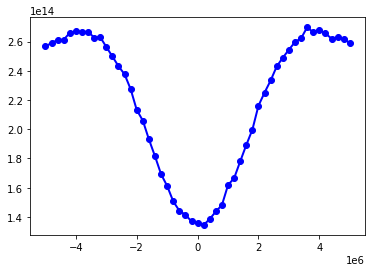

In [36]:
qubit_spectroscopy_sweep_values = []
for i in range(len(qubit_spectroscopy_sweep_results.results)):
    qubit_spectroscopy_sweep_values.append(qubit_spectroscopy_sweep_results.get_memory(i)[qubit])

plt.plot(freq_detunings, np.real(qubit_spectroscopy_sweep_values),'-o', color='blue', lw=2)
plt.show()

### Rabi oscillation

After finding the qubit frequency, we can use it to drive a coherent Rabi oscillation between the $|0\rangle$ and $|1\rangle$ states. Using Rabi oscillations we can find the amplitude needed for a $\pi$-pulse to flip $|0\rangle$ to $|1\rangle$ and vice-versa.

For this experiment we keep the duration and the width of the Rabi pulses constant, and sweep the amplitude.

In [37]:
pi_pulse_duration=200e-9
pi_pulse_width=10e-9

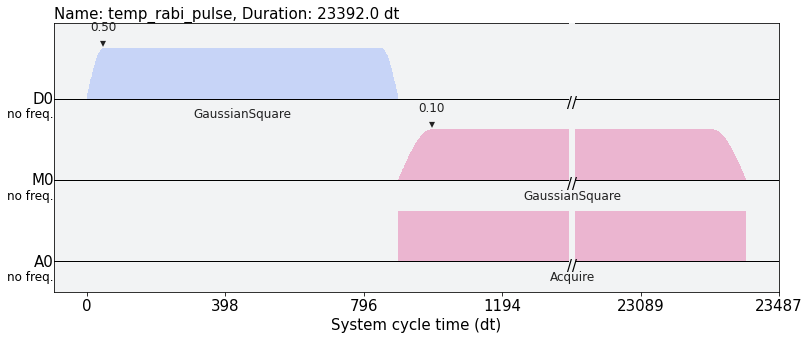

In [38]:
drive_amps=np.linspace(0,0.5,51)
rabi_pulses=[]
for amp in drive_amps:
    with pulse.build(name='temp_rabi_pulse',backend=backend) as temp_rabi_pulse:
        with pulse.align_sequential():
            pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(pi_pulse_duration//dt), amp, get_closest_multiple_of_16(pi_pulse_width//dt), risefall_sigma_ratio=1), drive_chan)
            pulse.call(readout)
            
    rabi_pulses.append(temp_rabi_pulse)
    
rabi_pulses[-1].draw(style=IQXDebugging())

In [39]:
num_shots = 4*1024 
rabi_sweep = assemble(rabi_pulses,
                       backend=backend, 
                       meas_level=1,
                       meas_return='avg',
                       shots=num_shots)

In [40]:
job_rabi_sweep = backend.run(rabi_sweep)
job_monitor(job_rabi_sweep)

rabi_sweep_results = job_rabi_sweep.result(timeout=120)

Job Status: job has successfully run


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.14999703601766706

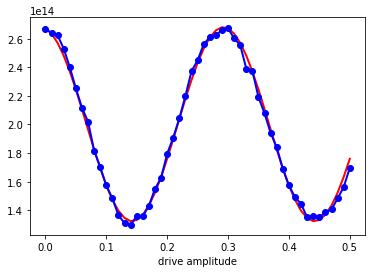

In [47]:
rabi_sweep_values = []
for i in range(len(rabi_sweep_results.results)):
    rabi_sweep_values.append(rabi_sweep_results.get_memory(i)[qubit])

popt, pcov= fit_rabi(drive_amps, np.real(rabi_sweep_values))

plt.plot(drive_amps, f_sine(drive_amps, *popt),'-', color='red', lw=2)
plt.plot(drive_amps, rabi_sweep_values,'-o', color='blue', lw=2)
plt.xlabel('drive amplitude')

pi_pulse_amp=1/(2*popt[0])
pi_pulse_amp

By extracting the Rabi oscillation period we find the amplitude for a $\pi$-pulse.

In [48]:
with pulse.build(name='pi_pulse',backend=backend) as pi_pulse:
        pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(pi_pulse_duration//dt), pi_pulse_amp, get_closest_multiple_of_16(pi_pulse_width//dt), risefall_sigma_ratio=1), drive_chan)

### $T_1$ measurement

Next, we measure the qubit relaxation time, commonly referred to as $T_1$, by exciting the qubit to the $|1\rangle$ state, and tracking its population after some time.

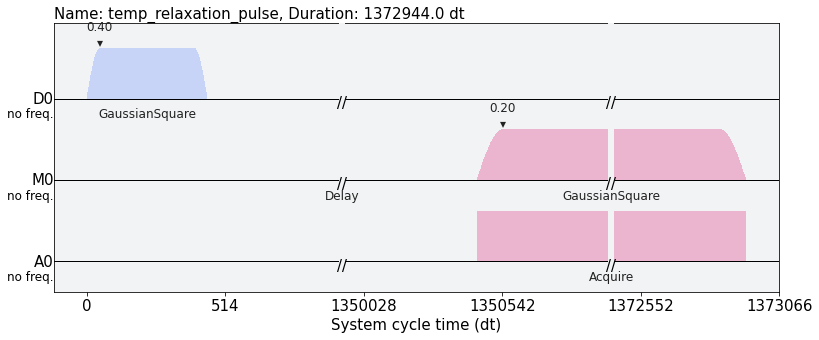

In [10]:
t1_delays=np.linspace(0,300e-6,51)

relaxation_pulses=[]
for delay in t1_delays:
    with pulse.build(name='temp_relaxation_pulse',backend=backend) as temp_relaxation_pulse:
        with pulse.align_sequential():
            pulse.call(pi_pulse)
            pulse.delay(get_closest_multiple_of_16(delay//dt), meas_chan)
            pulse.call(readout)
    relaxation_pulses.append(temp_relaxation_pulse)
    
relaxation_pulses[-1].draw(style=IQXDebugging())

In [11]:
num_shots = 4*1024 
qubit_relaxation_sweep = assemble(relaxation_pulses,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots)

In [12]:
job_qubit_relaxation_sweep = backend.run(qubit_relaxation_sweep)
job_monitor(job_qubit_relaxation_sweep)

qubit_relaxation_sweep_results = job_qubit_relaxation_sweep.result(timeout=120)

/tmp/ipykernel_59/1136663218.py:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_qubit_relaxation_sweep = backend.run(qubit_relaxation_sweep)


Job Status: job has successfully run


Text(0.5, 0, 'drive amplitude')

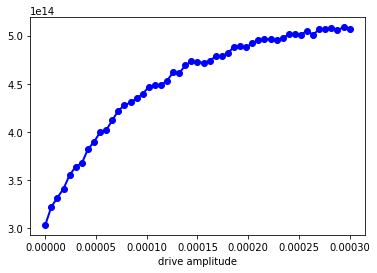

In [17]:
qubit_relaxation_values = []
for i in range(len(qubit_relaxation_sweep_results.results)):
    qubit_relaxation_values.append(qubit_relaxation_sweep_results.get_memory(i)[qubit])

plt.plot(t1_delays, np.real(qubit_relaxation_values),'-o', color='blue', lw=2)
plt.xlabel('drive amplitude')

### $T_2$ Ramsey measurement

Finally, we measure the qubit coherence time ($T_2$) using Ramsey measurements. 

In [49]:
with pulse.build(name='pi2_pulse',backend=backend) as pi2_pulse:
        pulse.play(pulse.GaussianSquare(get_closest_multiple_of_16(pi_pulse_duration//dt), pi_pulse_amp/2, get_closest_multiple_of_16(pi_pulse_width//dt), risefall_sigma_ratio=1), drive_chan)

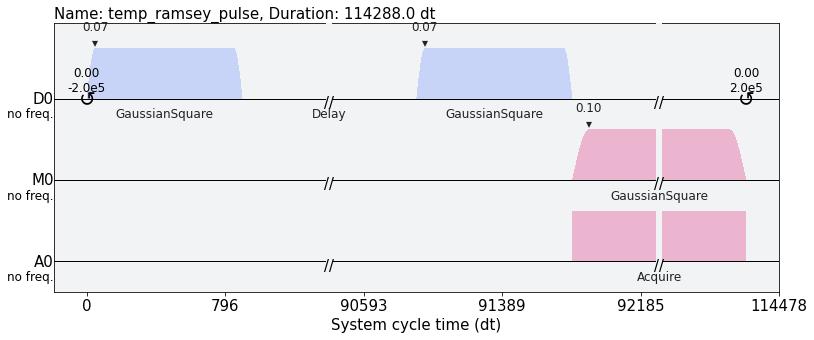

In [68]:
ramsey_delays=np.linspace(0,20e-6,51)
drive_detuning=-0.2e6

ramsey_pulses=[]
for delay in ramsey_delays:
    with pulse.build(name='temp_ramsey_pulse',backend=backend) as temp_ramsey_pulse:
        with pulse.align_sequential():
            #pulse.shift_frequency(drive_detuning, drive_chan)
            with pulse.frequency_offset(drive_detuning, drive_chan):
                pulse.call(pi2_pulse)
                pulse.delay(get_closest_multiple_of_16(delay//dt), drive_chan)
                #with ...
                #pulse.shift_frequency(drive_detuning, drive_chan)
                #pulse.freq_offset() context
                pulse.call(pi2_pulse)
                pulse.call(readout)
    ramsey_pulses.append(temp_ramsey_pulse)
    
ramsey_pulses[-1].draw(style=IQXDebugging())

In [69]:
num_shots = 8*1024 
ramsey_sweep = assemble(ramsey_pulses,
                       backend=backend, 
                       meas_level=1,
                       meas_return='avg',
                       shots=num_shots)

In [70]:
job_ramsey_sweep = backend.run(ramsey_sweep)
job_monitor(job_ramsey_sweep)

ramsey_sweep_results = job_ramsey_sweep.result(timeout=120)

Job Status: job has successfully run


Text(0.5, 0, 'drive amplitude')

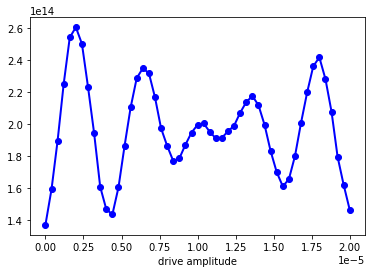

In [71]:
ramsey_values = []
for i in range(len(ramsey_sweep_results.results)):
    ramsey_values.append(ramsey_sweep_results.get_memory(i)[qubit])

plt.plot(ramsey_delays, np.real(ramsey_values),'-o', color='blue', lw=2)
plt.xlabel('drive amplitude')